# DL-модель для классификации состояния дерева (Good/Fair/Poor) по данным из NY 2015 Street Tree Census.

## Импорт библиотек

In [1]:
import os, sys

PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(PROJECT_DIR)
sys.path.append(PROJECT_DIR)


/workspaces/street_tree


In [2]:
import zipfile
import requests
import pandas as pd
import folium
from folium.plugins import HeatMap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from src.config import PATH_RAW, PATH_PROCESSED, URL, NAME_DATASET, PATH_MODELS, output_path
from src.dowload_datafraime import download_file
from src.visualization import plot_corr_matrix
from src.preprocessing import df_fillna, split_problems, convert_to_bool, encode_and_save_categorical, load_and_encode_categorical

2025-03-22 09:03:10,979 - src.utils - INFO - Logger is ready
2025-03-22 09:03:10,981 - src.utils - INFO - This is a test log message.
2025-03-22 09:03:10,983 - src.utils - INFO - PROJECT_DIR: /workspaces/street_tree
2025-03-22 09:03:10,984 - src.utils - INFO - PATH_LOGS: /workspaces/street_tree/logs
2025-03-22 09:03:10,984 - src.utils - INFO - PATH_DATA: /workspaces/street_tree/data
2025-03-22 09:03:10,985 - src.utils - INFO - PATH_RAW: /workspaces/street_tree/data/raw
2025-03-22 09:03:10,986 - src.utils - INFO - PATH_PROCESSED: /workspaces/street_tree/data/processed
2025-03-22 09:03:10,987 - src.utils - INFO - PATH_MODELS: /workspaces/street_tree/models
2025-03-22 09:03:10,988 - src.utils - INFO - PATH_REPORTS: /workspaces/street_tree/reports
2025-03-22 09:03:10,988 - src.utils - INFO - PATH_DOCS: /workspaces/street_tree/docs
2025-03-22 09:03:10,989 - src.utils - INFO - PATH_SRC: /workspaces/street_tree/src
2025-03-22 09:03:10,990 - src.utils - INFO - output_path: /workspaces/street_t

## Dowload dataset 2015 Street Tree Census - Tree Data

Описание датасета https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh/about_data

In [3]:
download_file(URL,PATH_RAW, output_path)

2025-03-22 09:03:11,003 - src.utils - INFO - Файл уже существует: /workspaces/street_tree/data/raw/2015-street-tree-census-tree-data.zip
2025-03-22 09:03:13,232 - src.utils - INFO - Файлы распакованы


In [4]:
df = pd.read_csv(f'{PATH_RAW}/{NAME_DATASET}.csv')
df.head(3)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,2015-08-27T00:00:00.000,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,2015-09-03T00:00:00.000,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,2015-09-05T00:00:00.000,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09


## Анализ данных

In [5]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.columns

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community_board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council_district',
       'census_tract', 'bin', 'bbl'],
      dtype='object')

In [6]:
# Распределение таргета
print(df[['status', 'health']].value_counts())
print(df[df['status'] != 'Alive']['status'].value_counts())
print(df[df['status'] != 'Alive']['health'].value_counts())
# Только у живых деревьев есть health status
df = df[df['status'] == 'Alive']
# Удалим строки с пропущенными значениями в health - это наш таргет
df.dropna(subset=['health'], inplace=True)  

df.shape

status  health
Alive   Good      528850
        Fair       96504
        Poor       26818
Name: count, dtype: int64
status
Stump    17654
Dead     13961
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


(652172, 45)

In [7]:
# По описанию датасета, в нем содержится информация о деревьях в Нью-Йорке
# Найдем количество деревьев в каждом районе
df.borough.value_counts()

borough
Queens           237974
Brooklyn         169744
Staten Island    101442
Bronx             80585
Manhattan         62427
Name: count, dtype: int64

In [8]:
df.steward.value_counts().sort_values(ascending=False).head(10)

steward
1or2       143557
3or4        19183
4orMore      1610
Name: count, dtype: int64

In [9]:
df.state.value_counts().sort_values(ascending=False).head(10)

state
New York    652172
Name: count, dtype: int64

In [10]:
df.stump_diam.value_counts().sort_values(ascending=False).head(10)

stump_diam
0    652172
Name: count, dtype: int64

In [11]:
df.nta_name.value_counts().sort_values(ascending=False).head(10)

nta_name
Annadale-Huguenot-Prince's Bay-Eltingville        12530
Great Kills                                       10267
Bayside-Bayside Hills                              9386
East New York                                      9188
Rossville-Woodrow                                  8842
New Springville-Bloomfield-Travis                  8142
Charleston-Richmond Valley-Tottenville             7913
Forest Hills                                       7330
Whitestone                                         7253
Georgetown-Marine Park-Bergen Beach-Mill Basin     7221
Name: count, dtype: int64

In [12]:
print(
    "Максимальное количество уникальных названий вида дерева",
    "на латыне для каждого обывательского названия:",
    df.groupby("spc_common").spc_latin.nunique().max(),
)

print(
    "Максимальное количество уникальных обывательских названий",
    "вида дерева для каждого названия на латыне:",
    df.groupby("spc_latin").spc_common.nunique().max(),
)

Максимальное количество уникальных названий вида дерева на латыне для каждого обывательского названия: 1
Максимальное количество уникальных обывательских названий вида дерева для каждого названия на латыне: 1


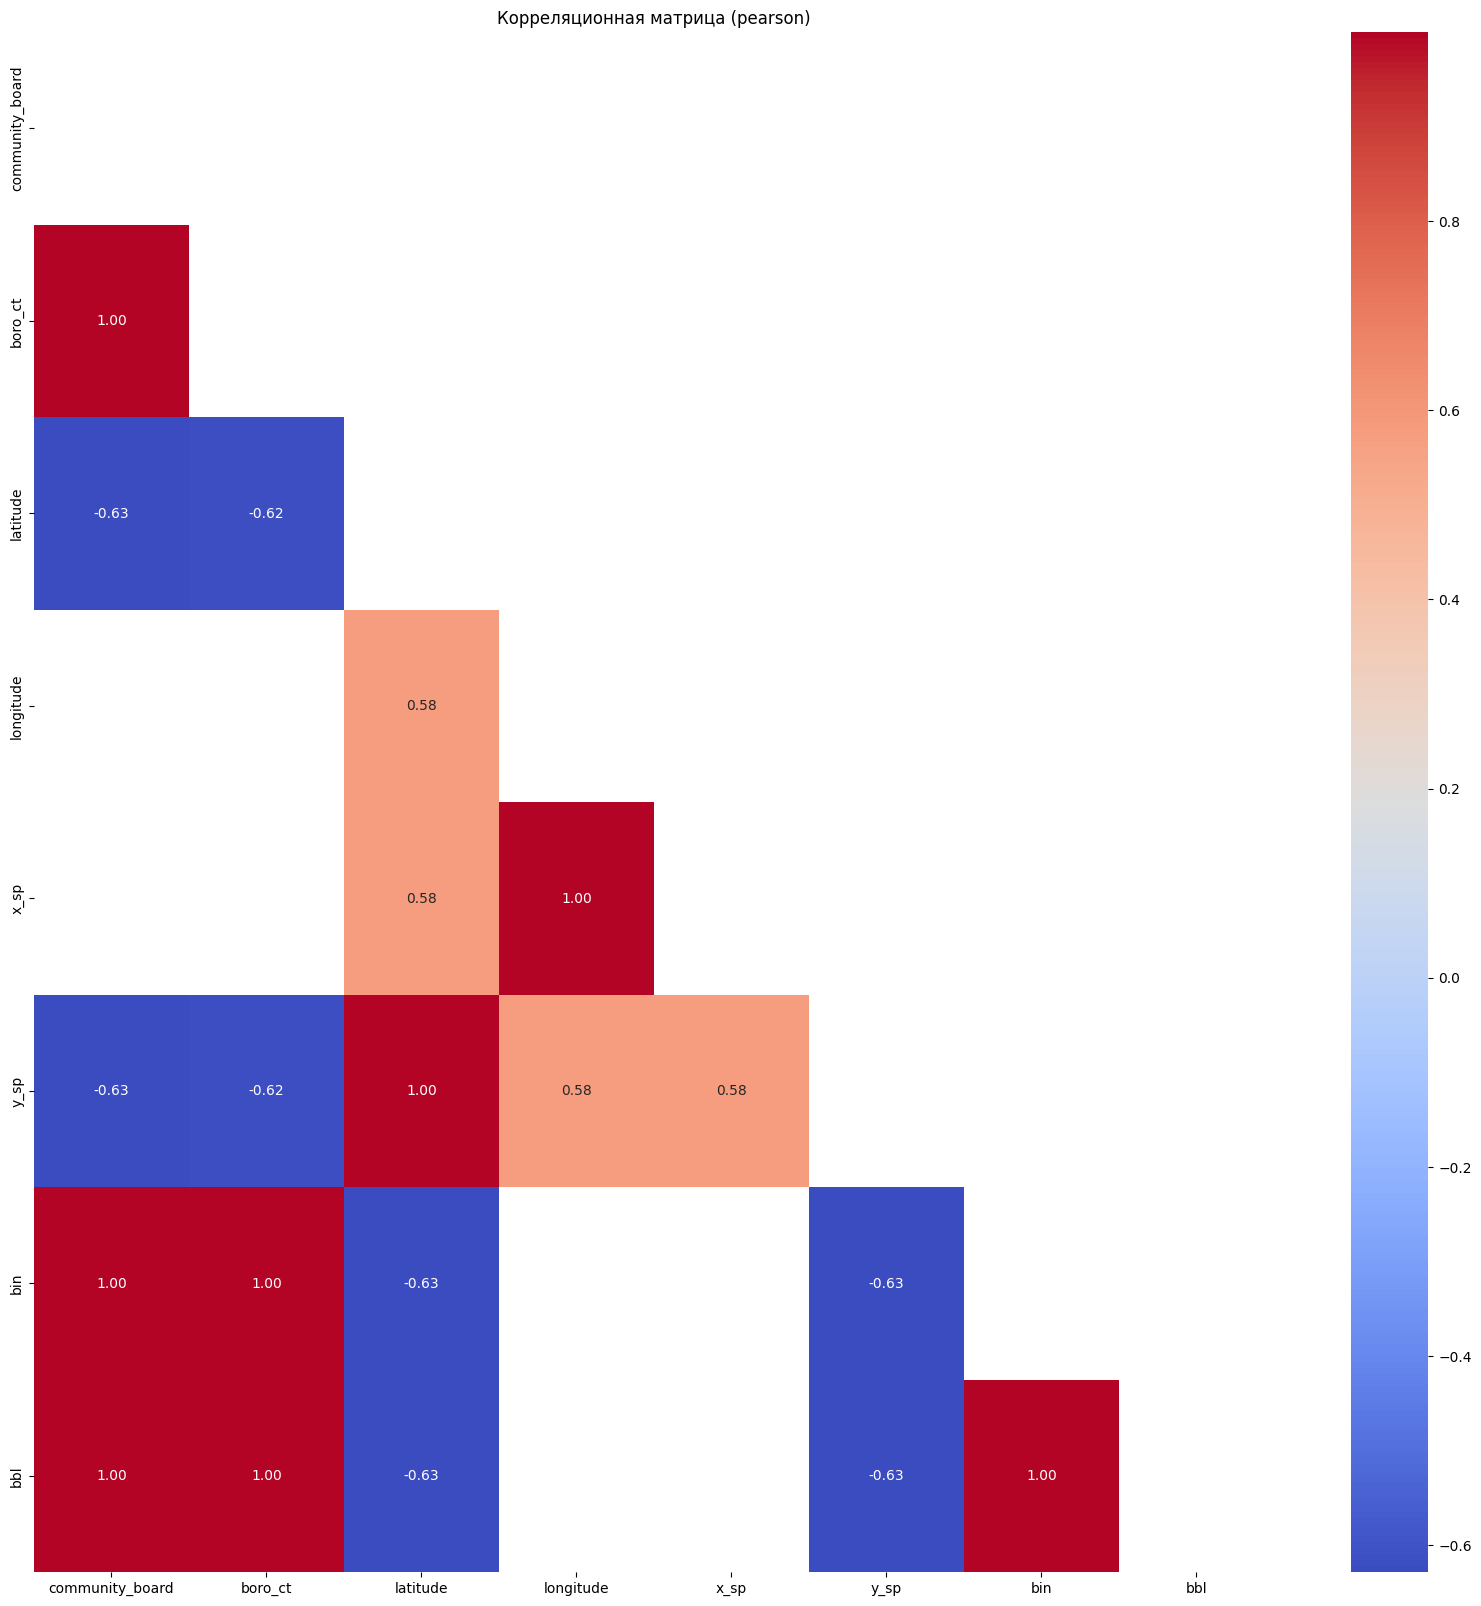

In [13]:
plot_corr_matrix(
    df[
        [
            "community_board",
            "boro_ct",
            "latitude",
            "longitude",
            "x_sp",
            "y_sp",
            "bin",
            "bbl",
        ]
    ],
    method="pearson",
)

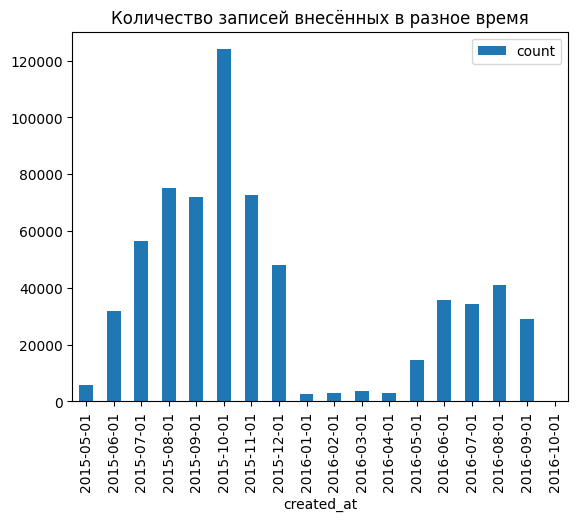

In [14]:
df.assign(created_at=lambda row: pd.to_datetime(row.created_at)) \
    .loc[:, ["created_at", "tree_id"]] \
    .resample("MS", on="created_at") \
    .count() \
    .rename(columns={"tree_id": "count"}) \
    .reset_index() \
    .assign(created_at=lambda row: row.created_at.dt.date) \
    .plot(
        kind="bar",
        x="created_at",
        y="count",
        title="Количество записей внесённых в разное время",
    ).get_figure().show()

plt.show()

Для задачи классификации состояния дерева (Good/Fair/Poor) некоторые столбцы могут быть не нужны,   
так как они не влияют на состояние дерева или являются избыточными.   
 Вот список столбцов, которые можно исключить:  
 -  status - все деревья живые, так как только у них есть значения healt(target) у мертвых и пенков нет
 -  state - все значения одинаковые ("New York")
 -  tree_id - уникальный идентификатор дерева
 -  created_at - дата создания записи. В течении года были записи
 -  stump_diam - диаметр пня. Все деревья живые, поэтому пень не имеет значения для состояния дерева и он везде ноль.
 -  borocode: Код района, не влияет на состояние. есть отдельный столбец borough
 -  x_sp: Координата X, коррелирует с longitude
 -  y_sp: Координата Y, коррелирует с latitude
 -  nta_name: есть отдельный столбец nta 
 -  council_district: район совета, не влияет на состояние
 -  census_tract: номер участка, не влияет на состояние
 -  nta_name - район, не влияет на состояние
 -  zip_city - код города
 -  spc_common - обывательское название. убираем т.к. везде есть латинское название
 -  community_board, bbl, bin - коррецирует с boro_ct



In [15]:
df_drop_columns = ['status', 'state', 'tree_id', 'created_at', 'stump_diam', 'address', 'spc_common',
                   'borocode', 'x_sp', 'y_sp', 'council_district', 'census_tract', 'nta_name',
                   'bin', 'zip_city', 'community_board', 'bbl']
df = df.drop(columns=df_drop_columns)
df.shape


(652172, 28)

In [16]:
df.isna().sum().sort_values(ascending=False).head(10)

guards       572306
steward      487822
problems     426328
spc_latin         5
sidewalk          1
curb_loc          0
tree_dbh          0
block_id          0
health            0
user_type         0
dtype: int64

array([[<Axes: title={'center': 'block_id'}>,
        <Axes: title={'center': 'tree_dbh'}>,
        <Axes: title={'center': 'postcode'}>],
       [<Axes: title={'center': 'cncldist'}>,
        <Axes: title={'center': 'st_assem'}>,
        <Axes: title={'center': 'st_senate'}>],
       [<Axes: title={'center': 'boro_ct'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>]], dtype=object)

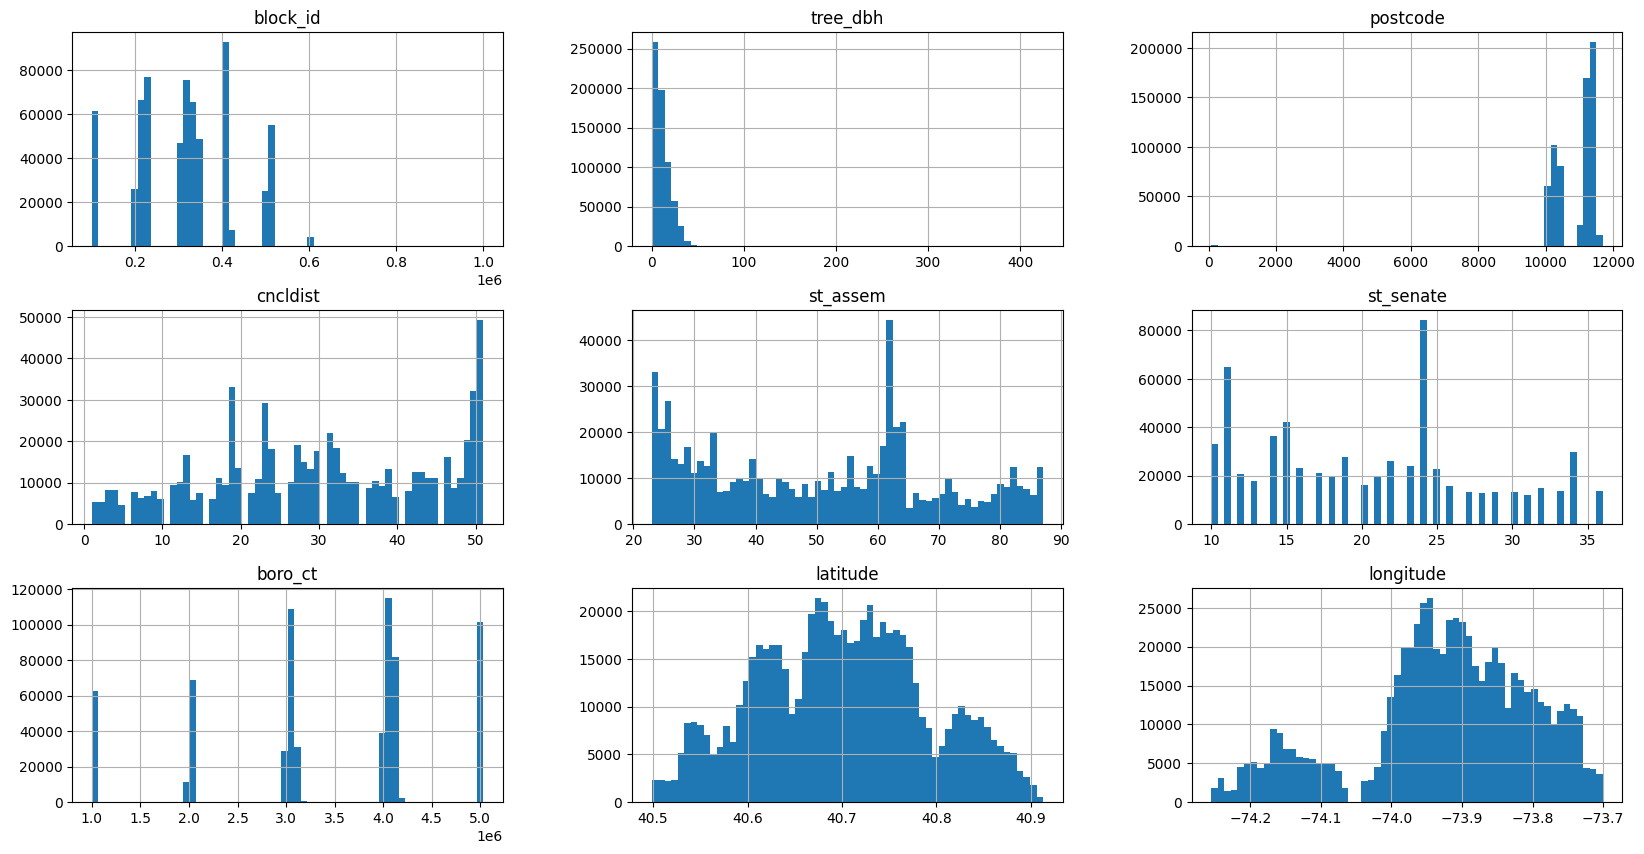

In [17]:
df.hist(bins=60, figsize=(20,10))


## Преобразование данных

In [18]:
df = df_fillna(df)
df.isna().sum().sort_values(ascending=False).head(10)

2025-03-22 09:03:28,091 - src.utils - INFO - Пропуски заполнены


block_id     0
tree_dbh     0
curb_loc     0
health       0
spc_latin    0
steward      0
guards       0
sidewalk     0
user_type    0
problems     0
dtype: int64

In [19]:
df = split_problems(df)

# Вывод первых строк для проверки
df[['trunklights', 'metalgrates', 'branchother', 'sneakers', 'wiresrope', 
    'branchlights', 'noproblem', 'rootother', 'stones', 'trunkother', 'num_problems']].head()

2025-03-22 09:03:30,581 - src.utils - INFO - {'noproblem', 'trunkother', 'sneakers', 'branchother', 'stones', 'branchlights', 'wiresrope', 'metalgrates', 'trunklights', 'rootother'} - уникальные проблемы


,trunklights,metalgrates,branchother,sneakers,wiresrope,branchlights,noproblem,rootother,stones,trunkother,num_problems
0,False,False,False,False,False,False,True,False,False,False,1
1,False,False,False,False,False,False,False,False,True,False,1
2,False,False,False,False,False,False,True,False,False,False,1
3,False,False,False,False,False,False,False,False,True,False,1
4,False,False,False,False,False,False,False,False,True,False,1


В колонке problems содержится информация о проблемах с деревьями
Разделили их на отдельные колонки
{'trunklights', 'metalgrates', 'branchother', 'sneakers', 'wiresrope', 'branchlights', 'noproblem', 'rootother', 'stones', 'trunkother'}
Это все уникальные проблемы для каждой мы создали колонку с будевым значением

In [20]:
df = convert_to_bool(df)

2025-03-22 09:03:37,282 - src.utils - INFO - Значения преобразованы в булевые


In [21]:
new_columns =  [
            "wiresrope",
            "trunk_wire",
            "metalgrates",
            "root_grate",
            "root_stone",
            "stones",
            "trunklights",
            "trnk_light",
            "brch_light",
            "branchlights",
            "brch_other",
            "branchother",
            "brch_shoe",
            "sneakers",
            "root_other",
            "rootother",
            "trnk_other",
            "trunkother",
        ]

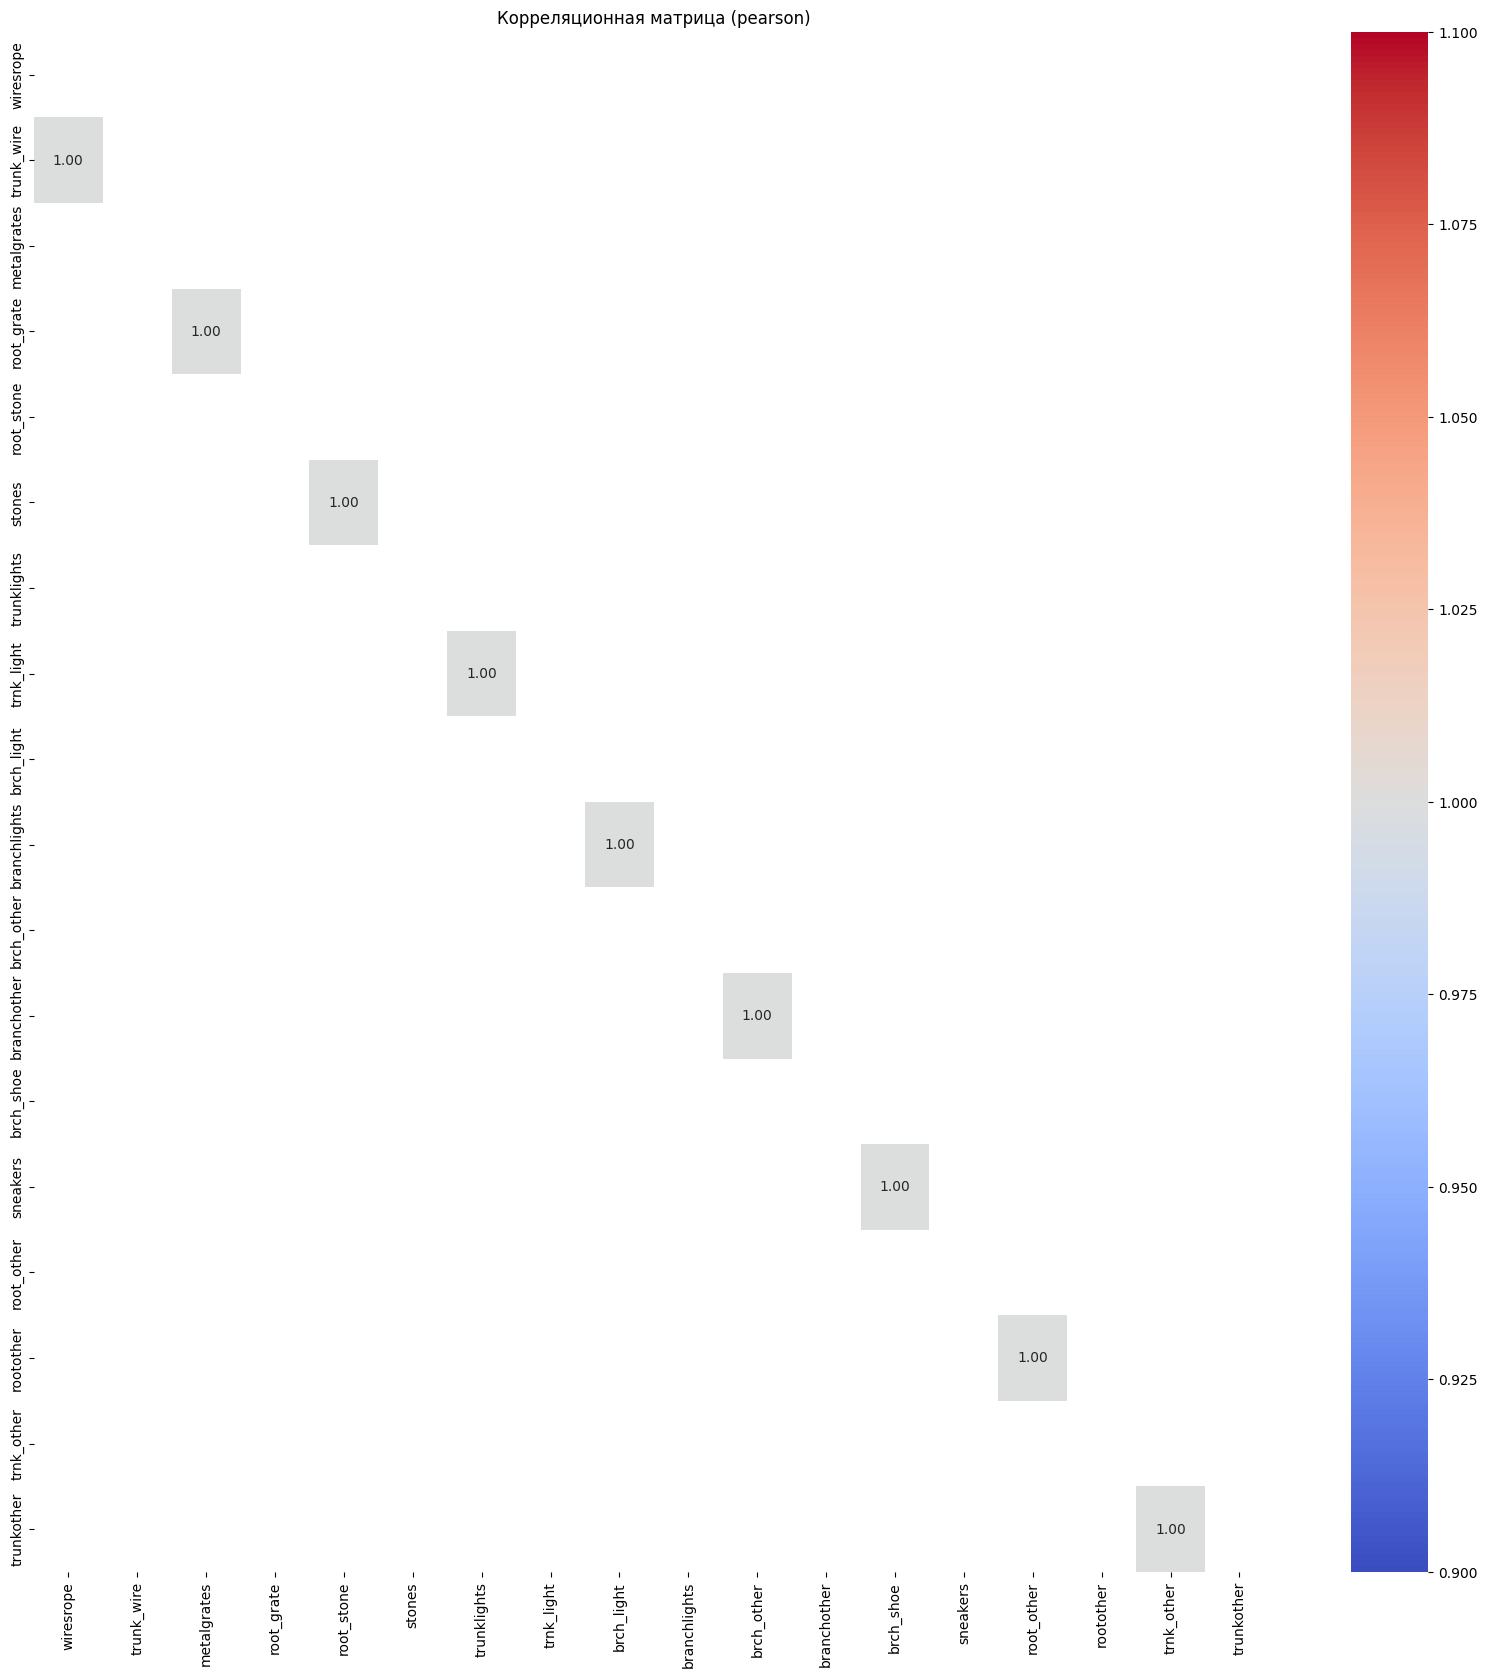

In [22]:
plot_corr_matrix(
    df[new_columns
    ],
    method="pearson",
)

Колонки из поля проблем повторяются и уже есть в датасете поэтому исключаем коррелирующиепризнаки

In [23]:
drop_columns = ['trunklights', 'metalgrates', 'branchother', 'sneakers', 'wiresrope', 
    'branchlights', 'noproblem', 'rootother', 'stones', 'trunkother']

In [24]:
df = df.drop(columns=drop_columns)
df.shape

(652172, 28)

In [25]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
categorical_columns

['health', 'spc_latin', 'steward', 'guards', 'user_type', 'borough', 'nta']

In [ ]:
df, label_encoders = encode_and_save_categorical(df, categorical_columns, PATH_MODELS)

In [ ]:
#df, label_encoders = load_and_encode_categorical(df, categorical_columns, PATH_MODELS)

2025-03-22 09:03:39,060 - src.utils - INFO - Категориальные признаки преобразованы с использованием загруженных LabelEncoders


ValueError: too many values to unpack (expected 2)

In [ ]:
# Вывод значений, закодированных энкодером для столбца 'health', вместе с соответствующими им числовыми кодами
health_classes = label_encoders['health'].classes_
health_codes = label_encoders['health'].transform(health_classes)

# Создание DataFrame для удобного отображения
health_mapping = pd.DataFrame({'Health': health_classes, 'Code': health_codes})
print(health_mapping)

  Health  Code
0   Fair     0
1   Good     1
2   Poor     2


## Расмотрим корреляцию

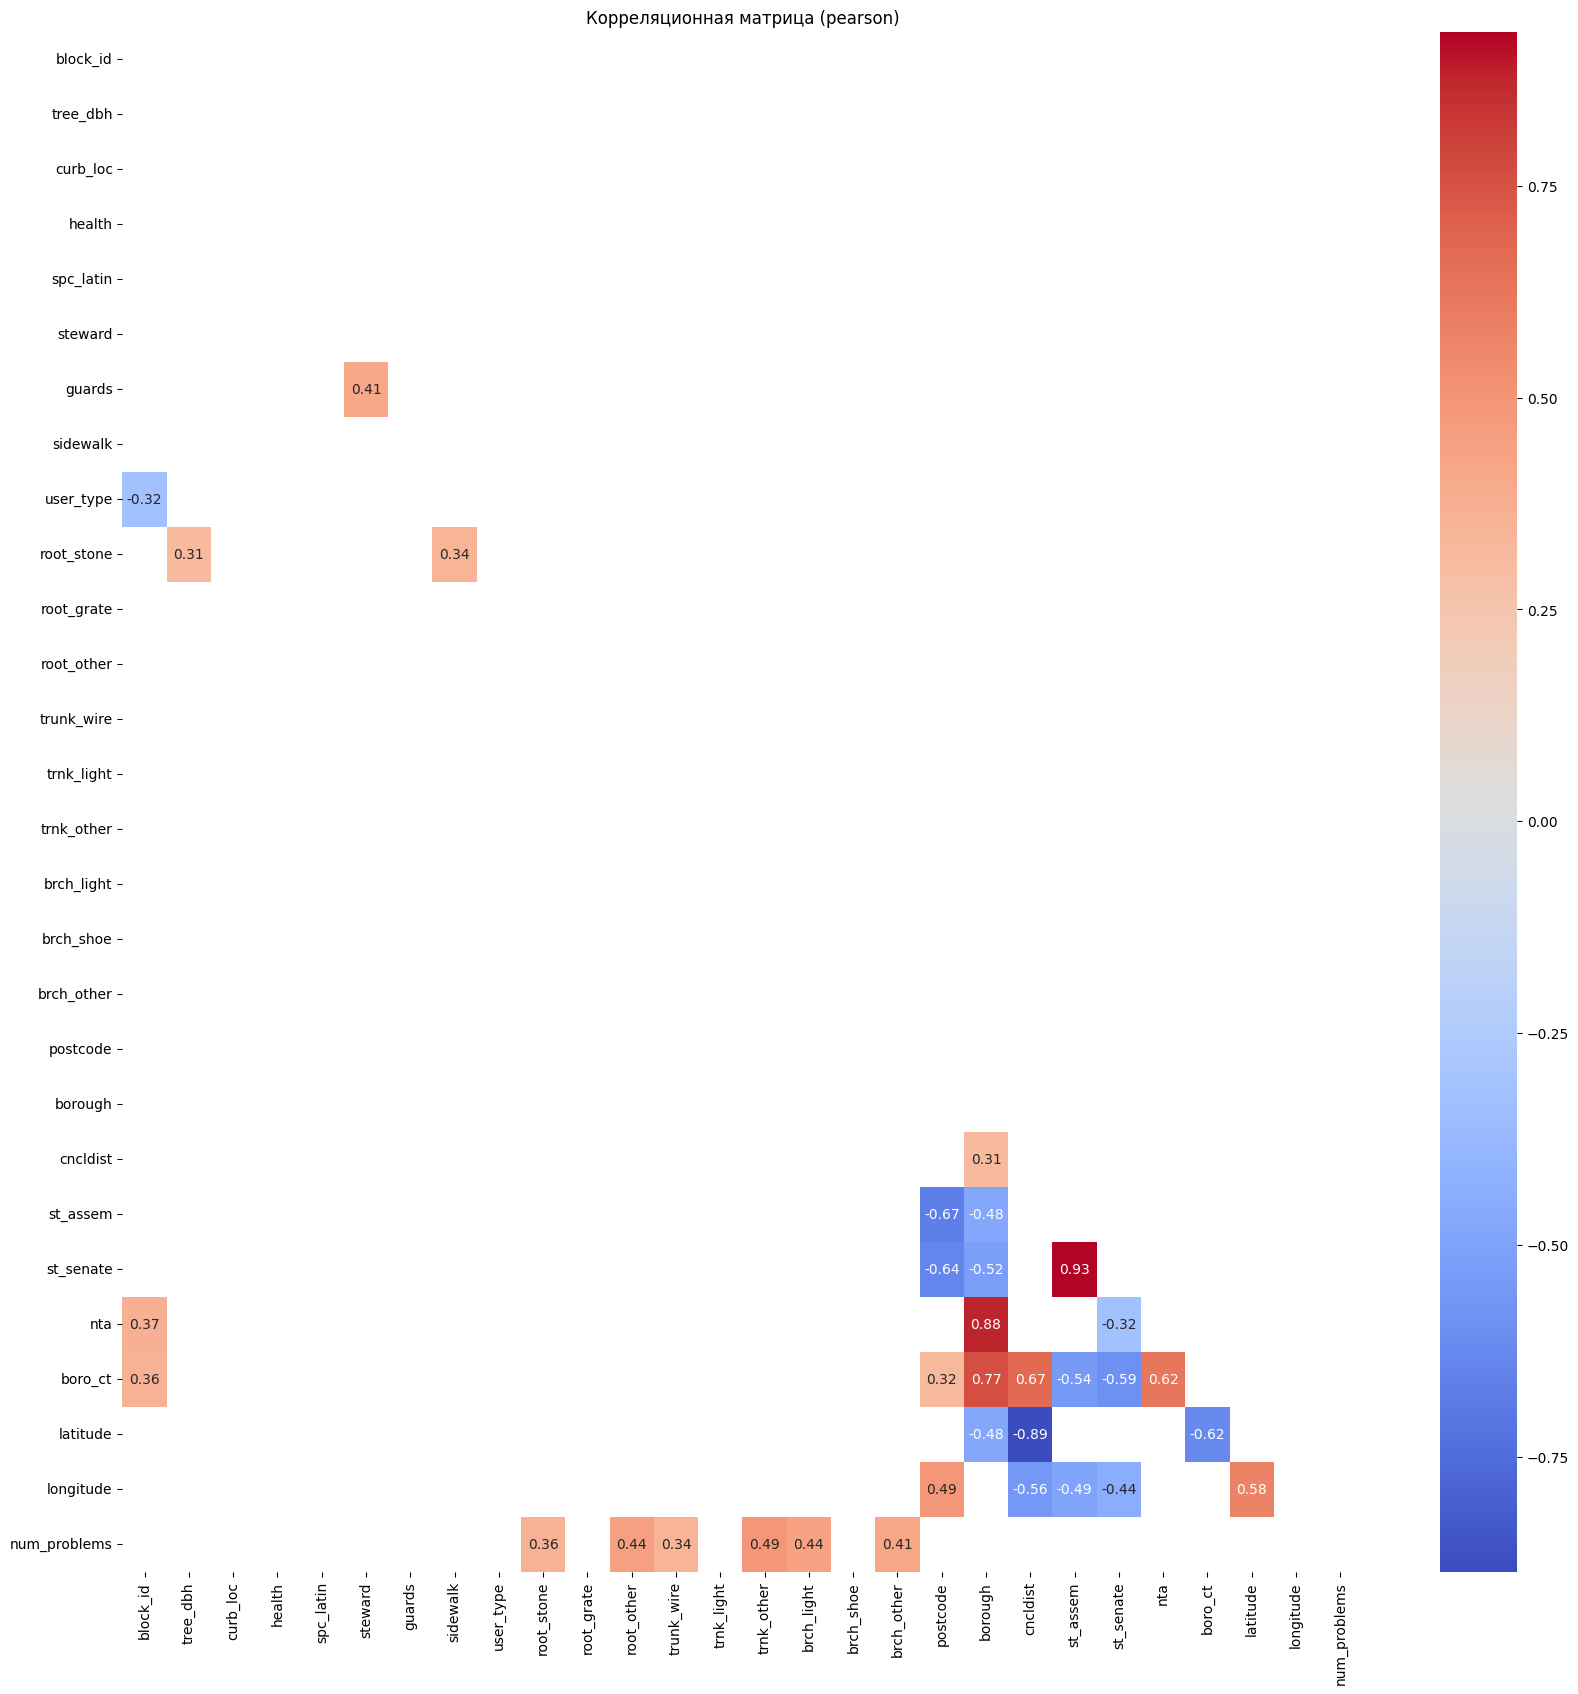

In [ ]:
# Порог корреляции 0.3 
# у нас много категориальных признаков  и они не имеют линейной зависимости между собой 
# Вызов функции
plot_corr_matrix(df, method='pearson', threshold=0.3)

In [ ]:
df.columns

Index(['block_id', 'tree_dbh', 'curb_loc', 'health', 'spc_latin', 'steward',
       'guards', 'sidewalk', 'user_type', 'root_stone', 'root_grate',
       'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light',
       'brch_shoe', 'brch_other', 'postcode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'boro_ct', 'latitude', 'longitude',
       'num_problems'],
      dtype='object')